# This is my capstone project for the Udacity Machine Learning Nanodegree.

Import the libraries needed.

In [1]:
import pandas as pd
import numpy as np
import keras as kr
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from os import listdir

Using TensorFlow backend.


Get the data.

In [2]:
directory = 'sandp500/individual_stocks_5yr'
#directory = 'OneDrive/Documents/Projects/MachineLearning/Udacity/Capstone/sandp500/individual_stocks_5yr'
#directory = 'Capstone/sandp500/individual_stocks_5yr'
directory_listing = listdir(directory)

In [3]:
symbols_list = []

for symbol in directory_listing:
    symb = symbol.split('_')[0]
    symbols_list.append(symb)

print(len(symbols_list))
print(symbols_list[0])

504
AAL


In [4]:
csv_file = '{}/{}_data.csv'.format(directory, symbols_list[0])
dataset = pd.read_csv(csv_file)

Since we already know the name of the specific stock we are trying to get from the name of the file, we can drop that column in the dataframe.

In [5]:
dataset = dataset.assign(trading_date = pd.to_datetime(dataset['Date']))

In [6]:
dataset = dataset.drop('Name', 1)
dataset = dataset.drop('Date', 1)
dataset.set_index(['trading_date'], inplace=True)

In [7]:
dataset['NextDayClose'] = dataset['Close'].shift(-1)

In [8]:
dataset.head(10)

Open   High    Low  Close    Volume  NextDayClose
trading_date                                                    
2013-12-09    23.85  25.44  23.45  24.60  43197268         24.88
2013-12-10    24.50  25.17  24.41  24.88  18660625         25.99
2013-12-11    25.48  27.20  25.37  25.99  38843371         25.45
2013-12-12    26.20  26.71  25.45  25.45  19981824         26.23
2013-12-13    25.75  26.30  25.52  26.23  12192421         26.61
2013-12-16    26.63  26.77  26.35  26.61  13190945         26.10
2013-12-17    26.48  26.59  25.95  26.10  11413199         26.23
2013-12-18    25.99  26.23  25.55  26.23   9994162         26.12
2013-12-19    26.12  26.49  25.82  26.12   6916497         26.33
2013-12-20    26.18  26.49  26.14  26.33   8530924         26.18

In [9]:
#below is the Daily Returns calculation to put into the Sharpe Ratio. 
#df = dataset.assign(Daily_Returns = np.divide((dataset.Open - dataset.Close), dataset.Close) * 100)

#Below is the calculation for the Sharpe Ratio column. 
#df = df.assign(Sharpe_Ratio = np.divide((df.Daily_Returns - 0.046), np.std(np.array([df.Open, df.High, df.Low, df.Close]))))

#Below is the rate of change (momentum) for the specific stock. 
#df = df.assign(Rate_of_Change = (np.divide(df.Close, df.Open) - 1) * 100)

df = dataset.assign(Difference_of_Close = dataset['Close'].diff())

In [10]:
df.head(10)

Open   High    Low  Close    Volume  NextDayClose  \
trading_date                                                       
2013-12-09    23.85  25.44  23.45  24.60  43197268         24.88   
2013-12-10    24.50  25.17  24.41  24.88  18660625         25.99   
2013-12-11    25.48  27.20  25.37  25.99  38843371         25.45   
2013-12-12    26.20  26.71  25.45  25.45  19981824         26.23   
2013-12-13    25.75  26.30  25.52  26.23  12192421         26.61   
2013-12-16    26.63  26.77  26.35  26.61  13190945         26.10   
2013-12-17    26.48  26.59  25.95  26.10  11413199         26.23   
2013-12-18    25.99  26.23  25.55  26.23   9994162         26.12   
2013-12-19    26.12  26.49  25.82  26.12   6916497         26.33   
2013-12-20    26.18  26.49  26.14  26.33   8530924         26.18   

              Difference_of_Close  
trading_date                       
2013-12-09                    NaN  
2013-12-10                   0.28  
2013-12-11                   1.11  
2013-12-12                  -0.54  
2013-12-13                   0.78  
2013-12-16                   0.38  
2013-12-17                  -0.51  
2013-12-18                   0.13  
2013-12-19                  -0.11  
2013-12-20                   0.21

This code is for comparing the different columns of the raw data. 

In [11]:
df = df.drop(['Open', 'High', 'Low', 'Volume'], axis=1)

In [12]:
df.head(10)

Close  NextDayClose  Difference_of_Close
trading_date                                          
2013-12-09    24.60         24.88                  NaN
2013-12-10    24.88         25.99                 0.28
2013-12-11    25.99         25.45                 1.11
2013-12-12    25.45         26.23                -0.54
2013-12-13    26.23         26.61                 0.78
2013-12-16    26.61         26.10                 0.38
2013-12-17    26.10         26.23                -0.51
2013-12-18    26.23         26.12                 0.13
2013-12-19    26.12         26.33                -0.11
2013-12-20    26.33         26.18                 0.21

The following is graphing a few of the graphs with the opening price and the volume on one graph to compare with two different axis'.  I thought to do this as a comparison between the opening price (which all the raw data features follow roughly the same line) and the volume feature.  Since the volume feature is important. [http://www.investopedia.com/terms/v/volume.asp]

In [13]:
def getting_preprocessed_data(symbol):
        csv_file = '{}/{}_data.csv'.format(directory, symbol)
        df = pd.read_csv(csv_file)
        df = df.drop('Name', 1)
        df.set_index('Date', inplace=True)
        # below was found at https://stackoverflow.com/questions/29314033/python-pandas-dataframe-remove-empty-cells
        df['Open'].replace('', np.nan, inplace=True)
        df.dropna(subset=['Open'], inplace=True)
        return df

def plotting_stocks(symbols_list, amount_of_stocks=0):
    if amount_of_stocks == 0:
        amount_of_stocks = len(symbols_list)
        
    for symbol in symbols_list[:amount_of_stocks]:
        fig, ax = plt.subplots()
        fig.subplots_adjust(right=0.7)
        df = getting_preprocessed_data(symbol)
        print(symbol)
        df.Open.plot(ax=ax, style='b-', figsize=(20,10))
        # same ax as above since it's automatically added on the right
        df.Volume.plot(ax=ax, style='r-', secondary_y=True, figsize=(20,10))
        # add legend --> take advantage of pandas providing us access
        # to the line associated with the right part of the axis
        #ax.legend([ax.get_lines()[0], ax.get_lines()[0]], ['Open','Volume'], bbox_to_anchor=(1.5, 0.5))
        plt.show()
        #below is the Daily Returns calculation to put into the Sharpe Ratio. 
        df_preprocessed = df.assign(Daily_Returns = np.divide((df.Open - df.Close), df.Close) * 100)

        #Below is the calculation for the Sharpe Ratio column. 
        df_preprocessed = df_preprocessed.assign(Sharpe_Ratio = np.divide((df_preprocessed.Daily_Returns - 0.046), np.std(np.array([df_preprocessed.Open, df_preprocessed.High, df_preprocessed.Low, df_preprocessed.Close]))))

        #Below is the rate of change (momentum) for the specific stock. 
        df_preprocessed = df_preprocessed.assign(Rate_of_Change = (np.divide(df_preprocessed.Close, df_preprocessed.Open) - 1) * 100)

        #df.plot.scatter(x='Open', y='Volume', label="AAL")
        log_df = np.log(df)
        log_df.plot.scatter(x='Volume', y='Open', label="AAL", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Open', y='Sharpe_Ratio', label="Sharpe Ratio Open", figsize=(20,10))
        plt.show()
        df_preprocessed.plot.scatter(x='Volume',y='Sharpe_Ratio', label="Sharpe Ratio Close", figsize=(20,10), use_index=True)
        plt.show()

AAL


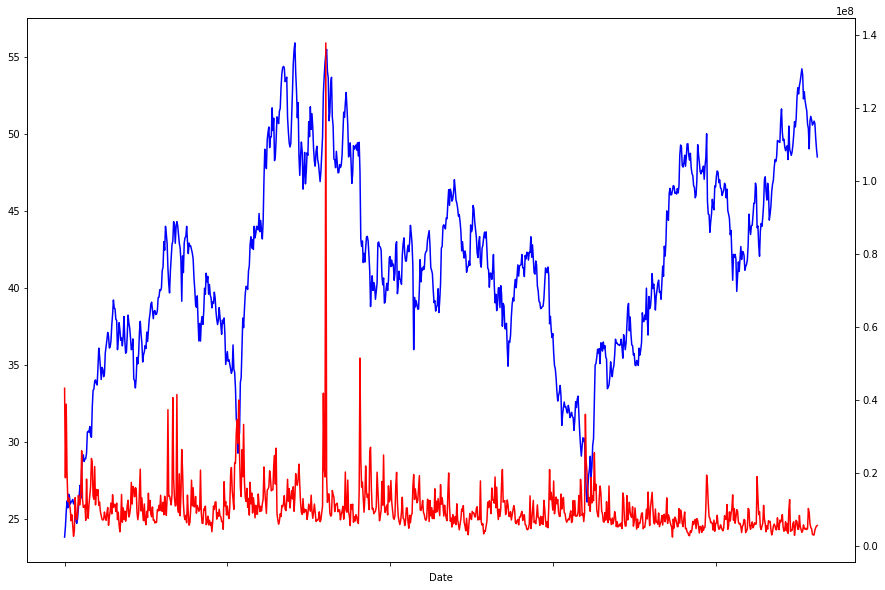

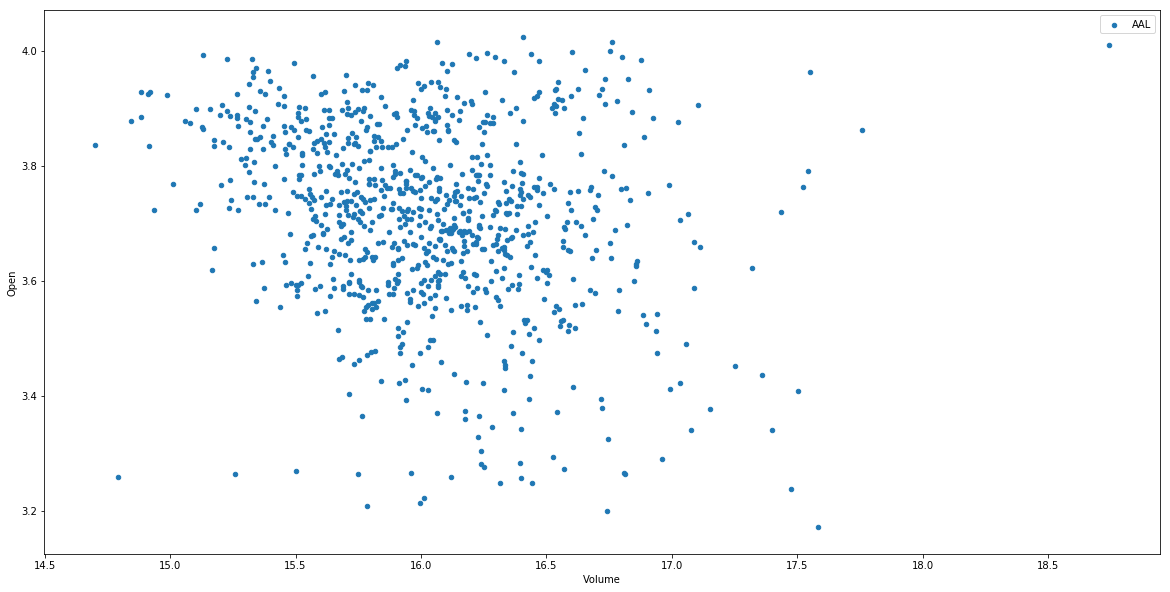

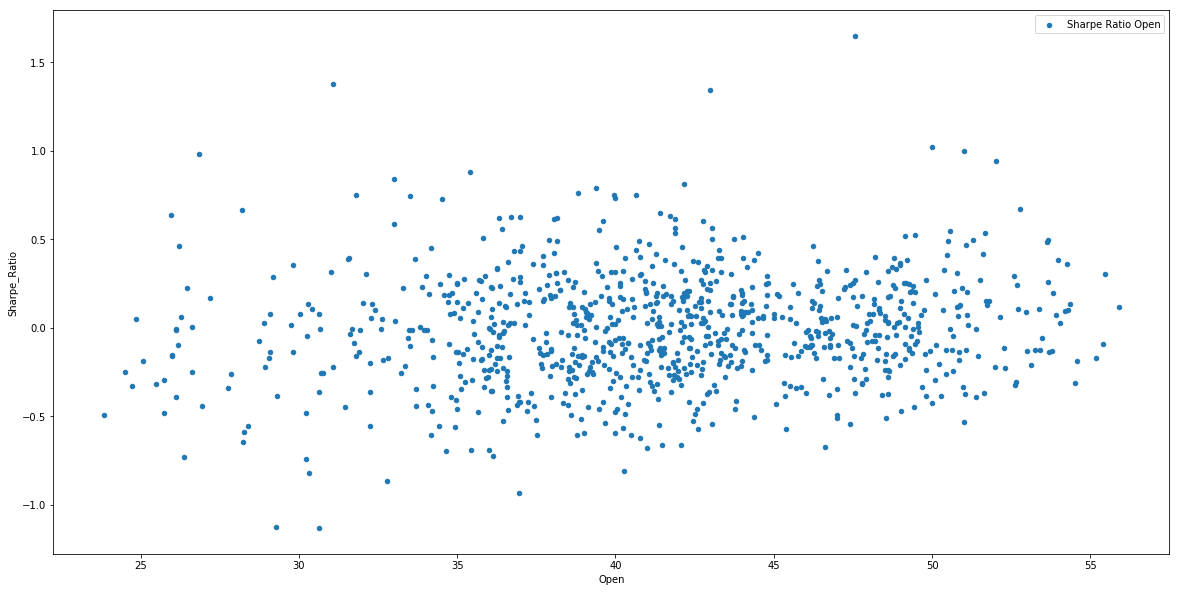

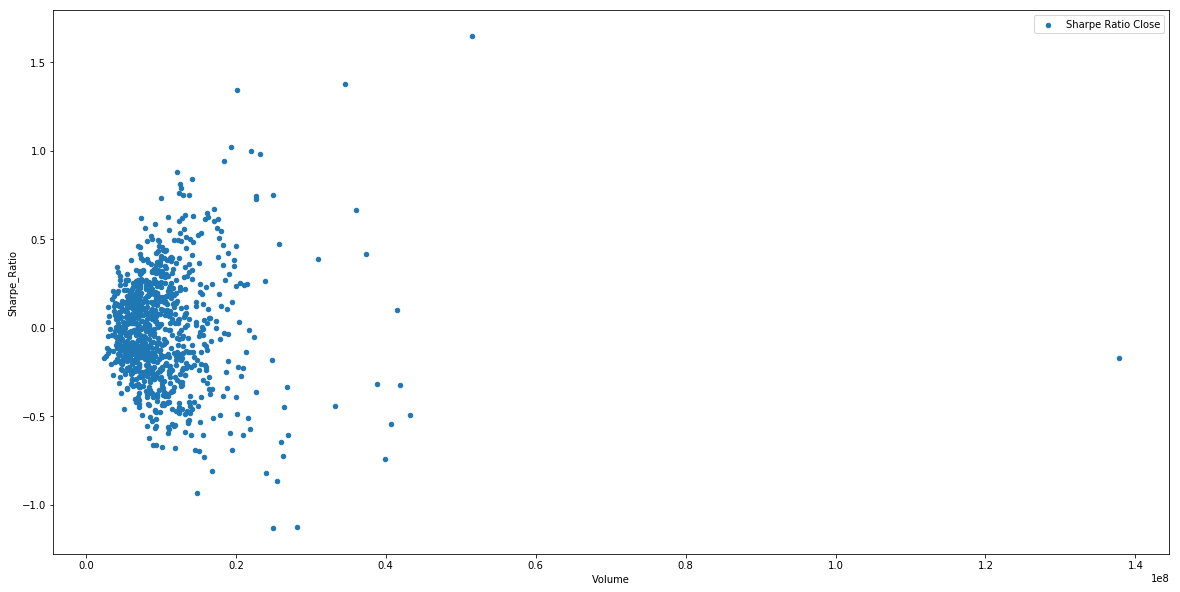

AAPL


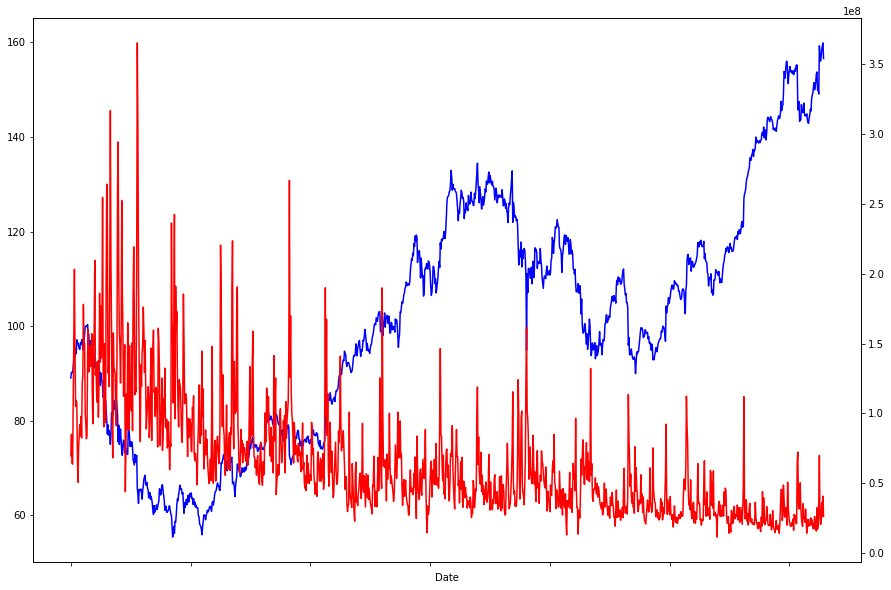

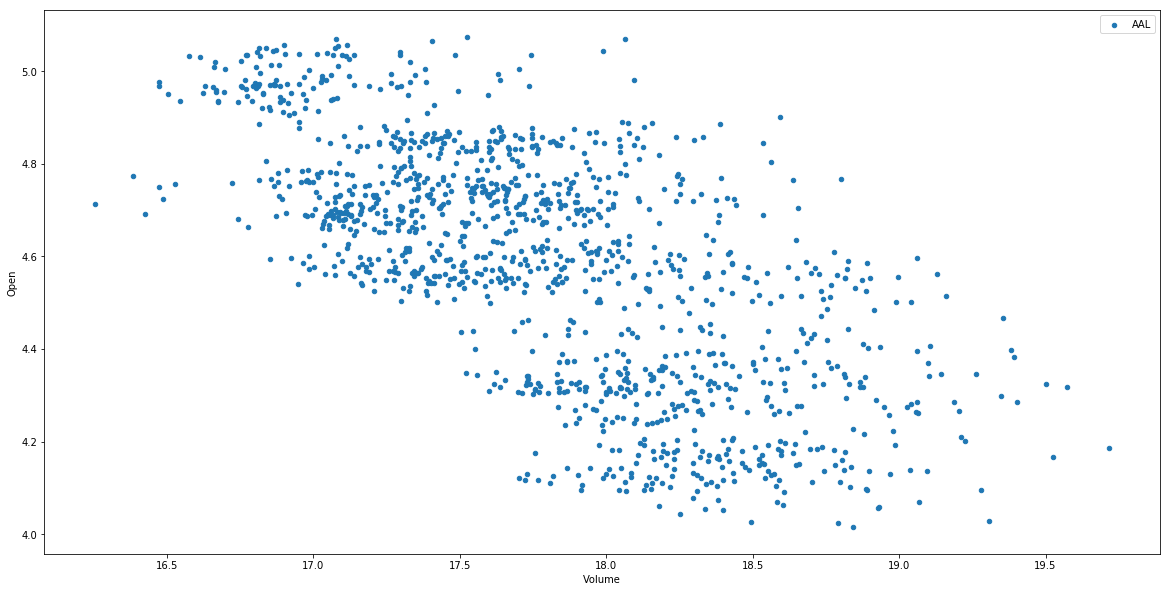

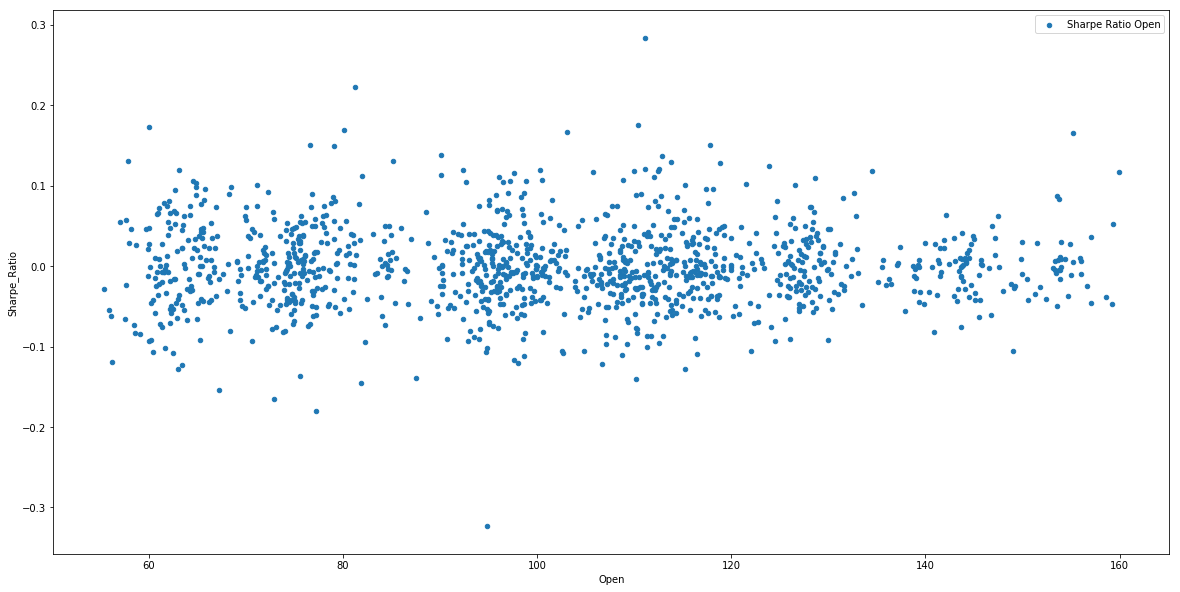

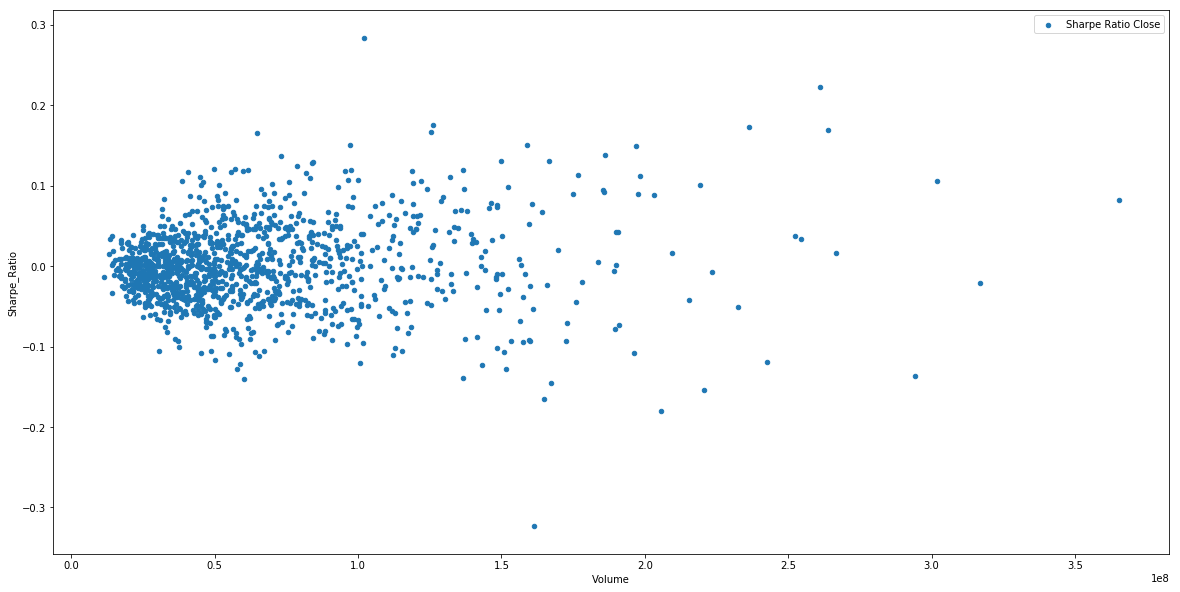

AAP


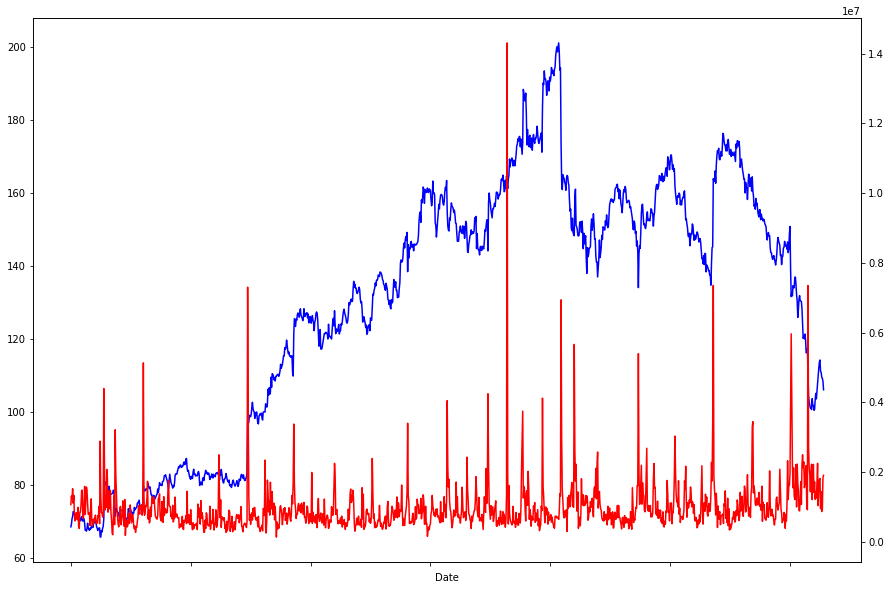

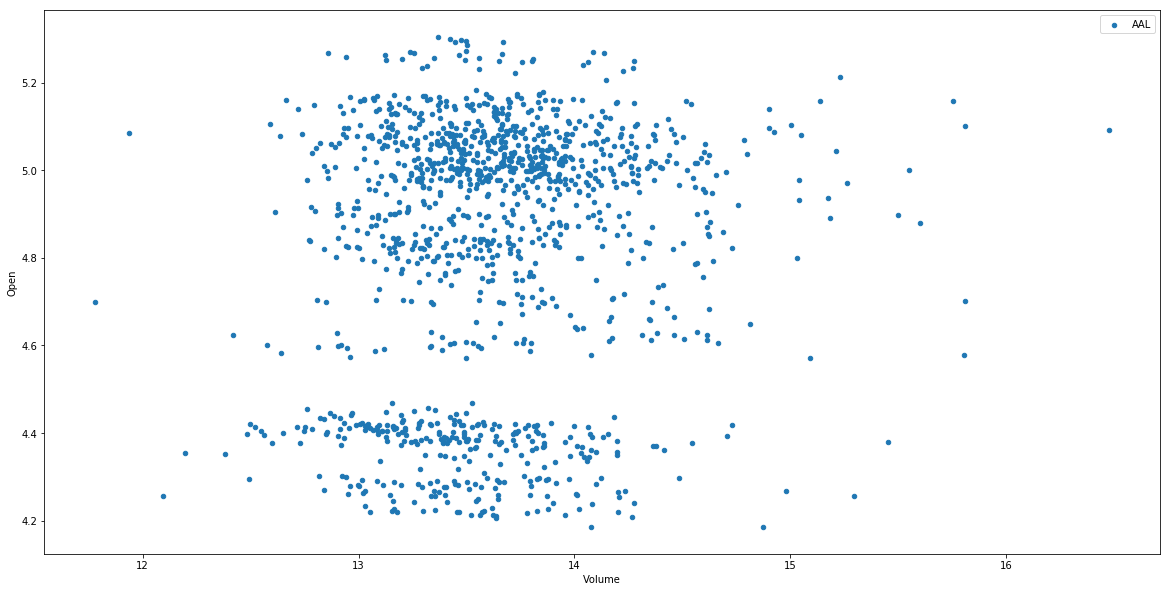

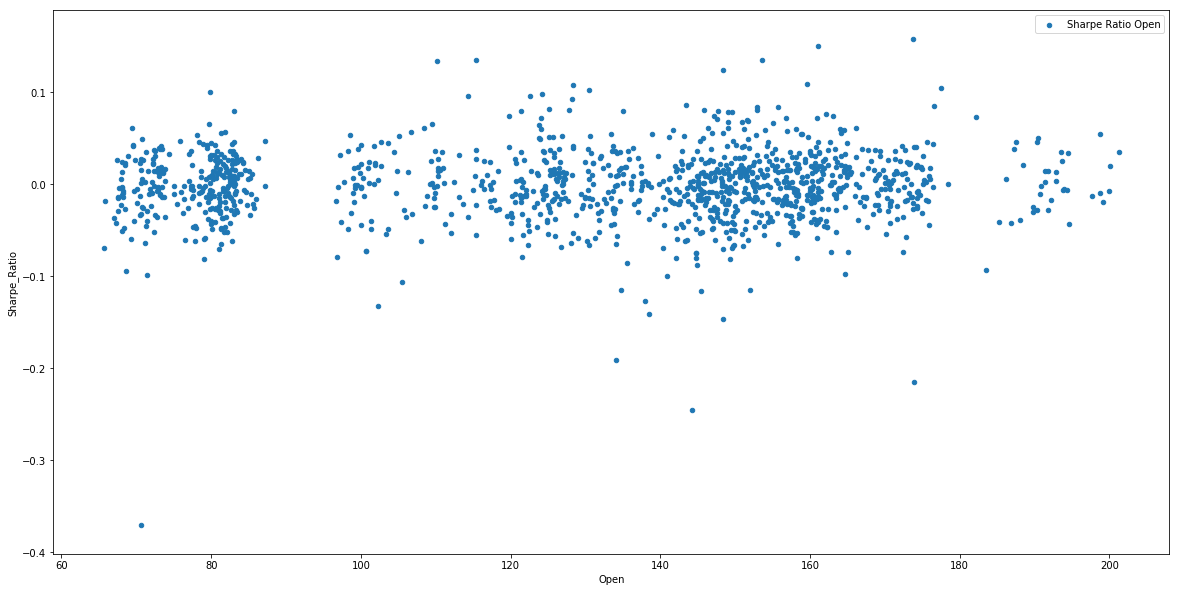

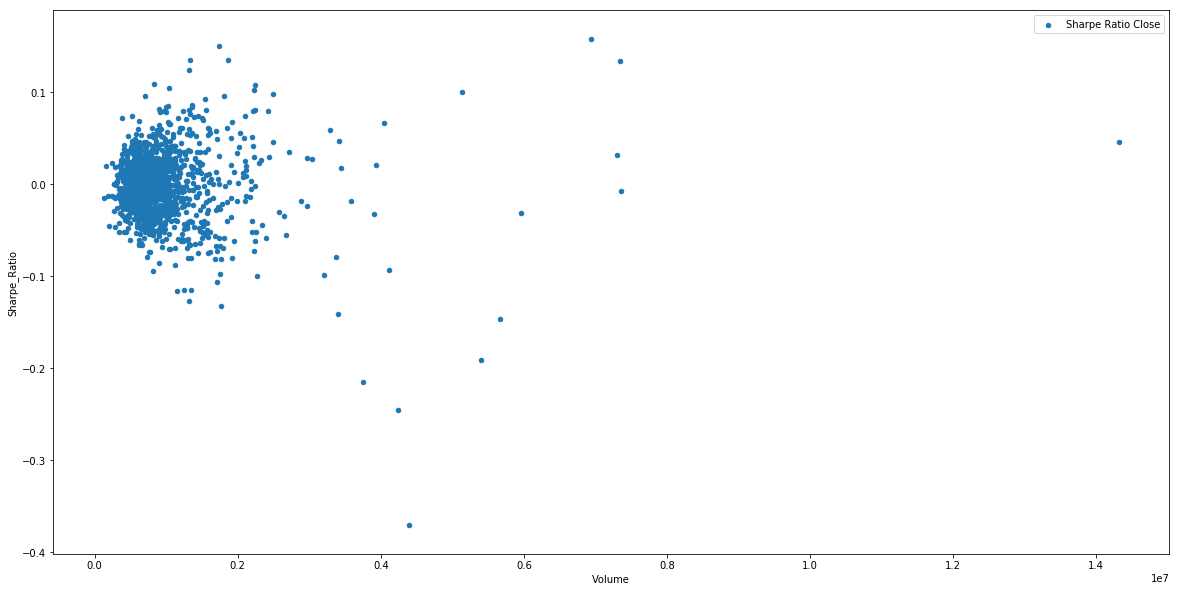

ABBV


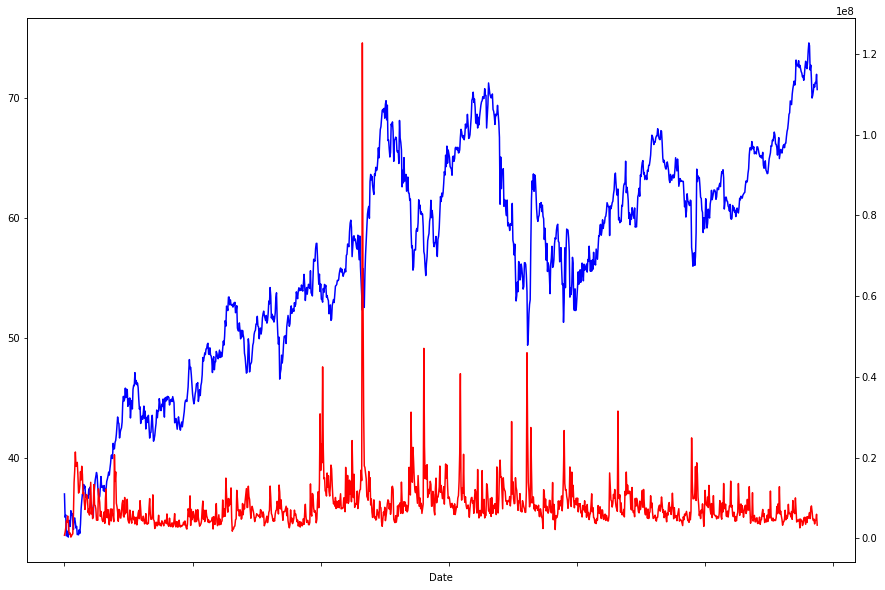

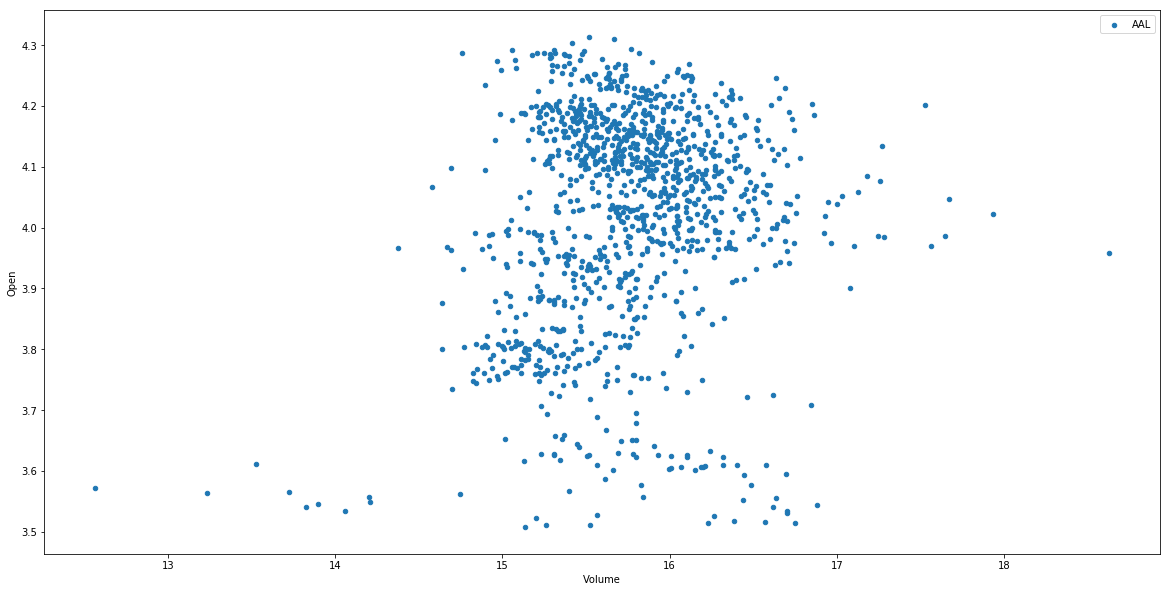

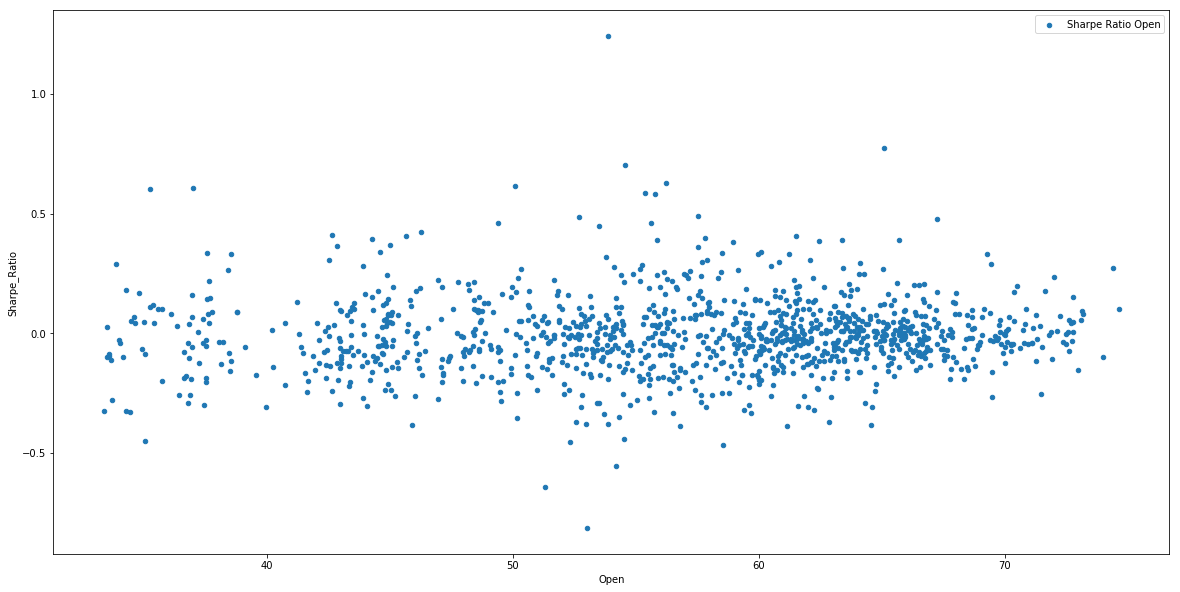

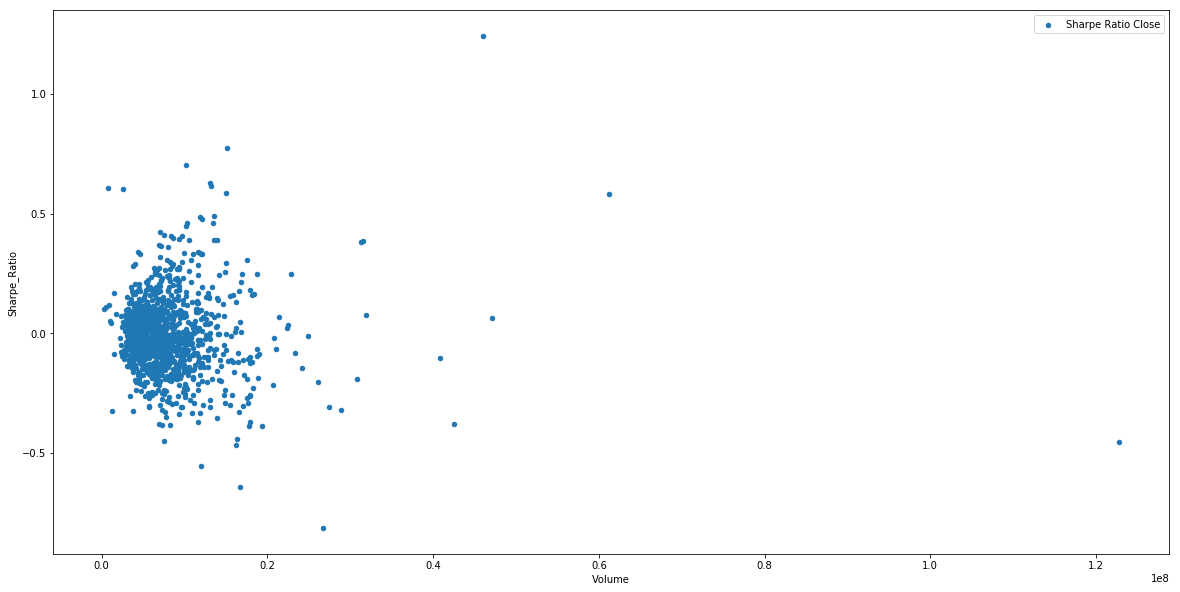

ABC


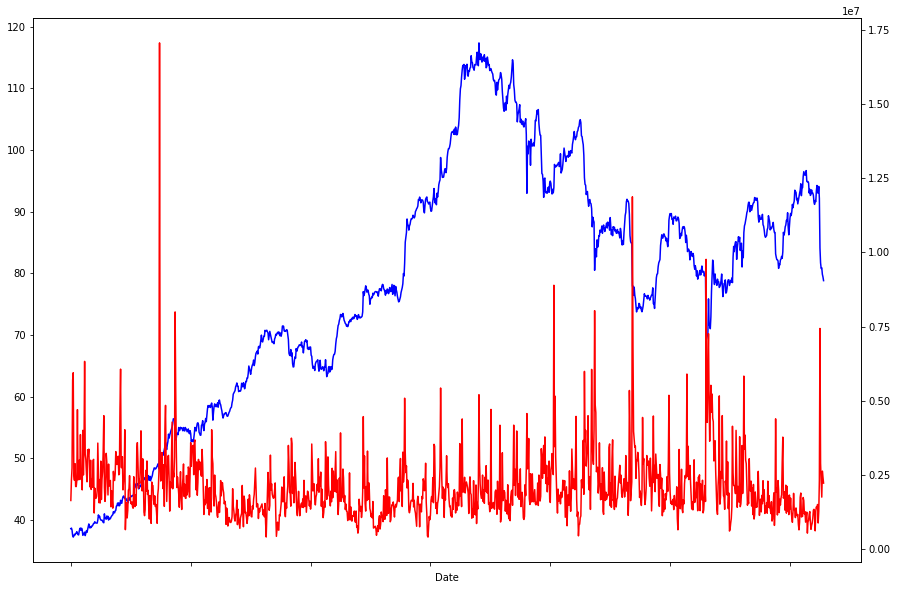

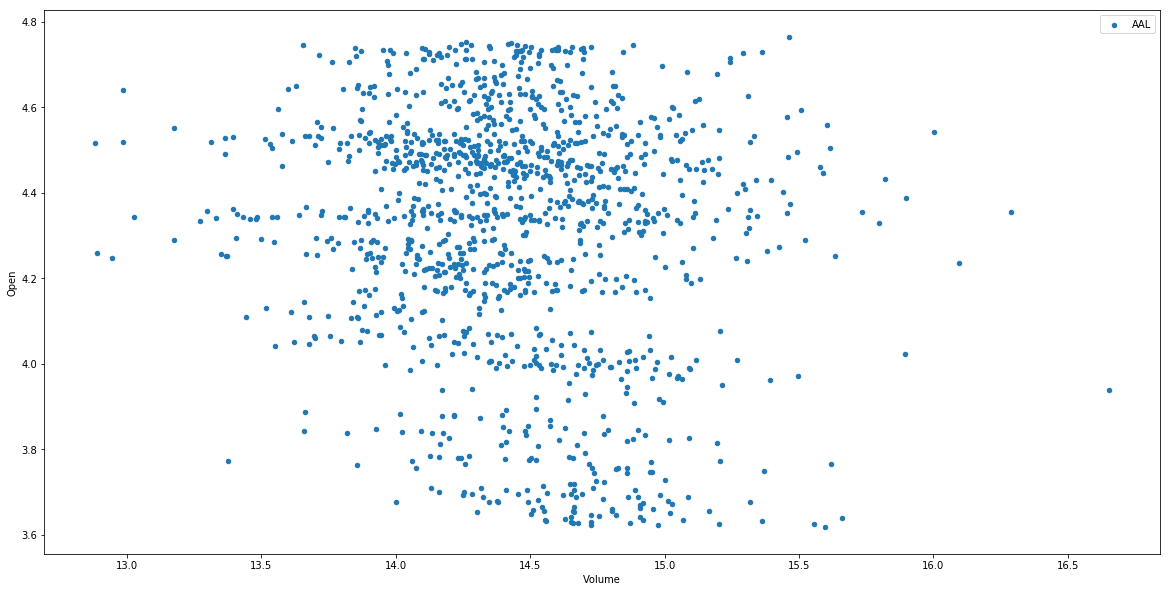

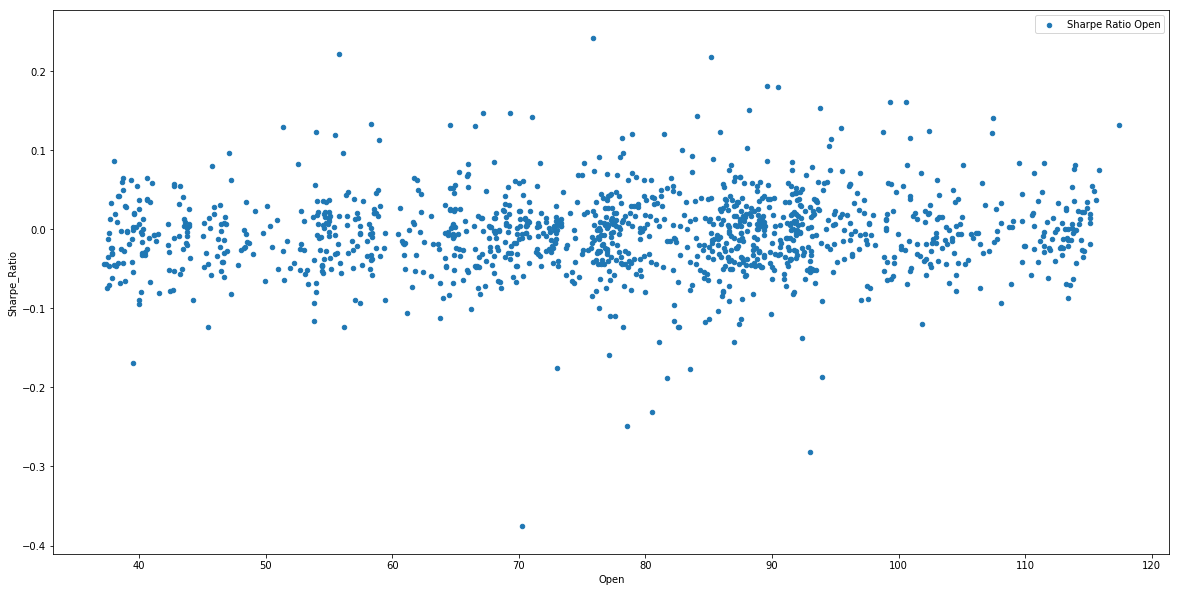

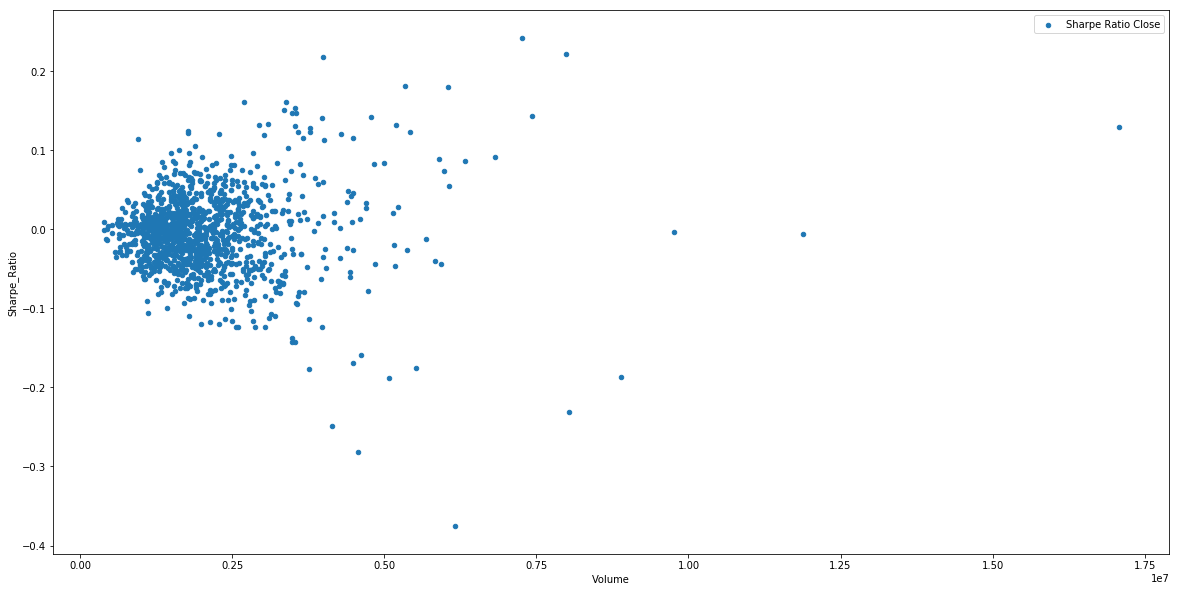

ABT


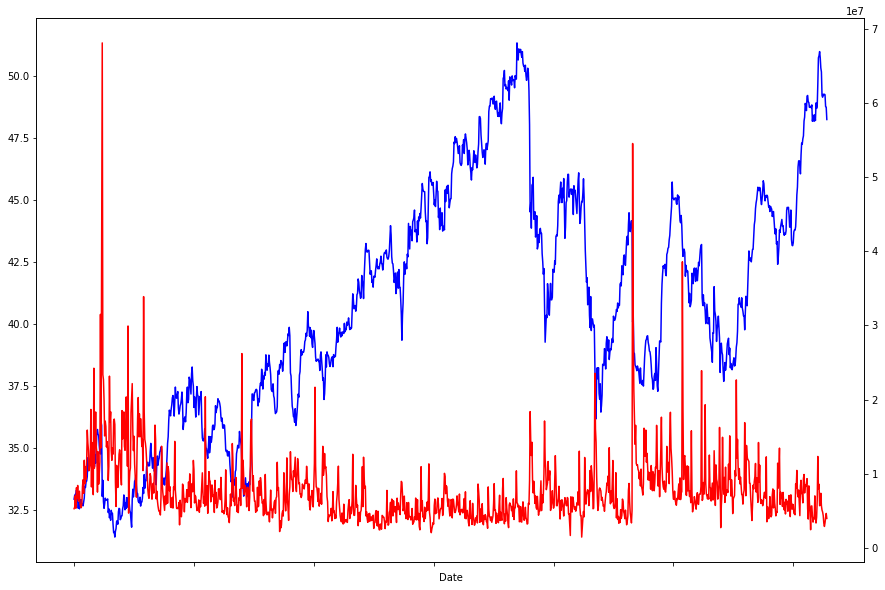

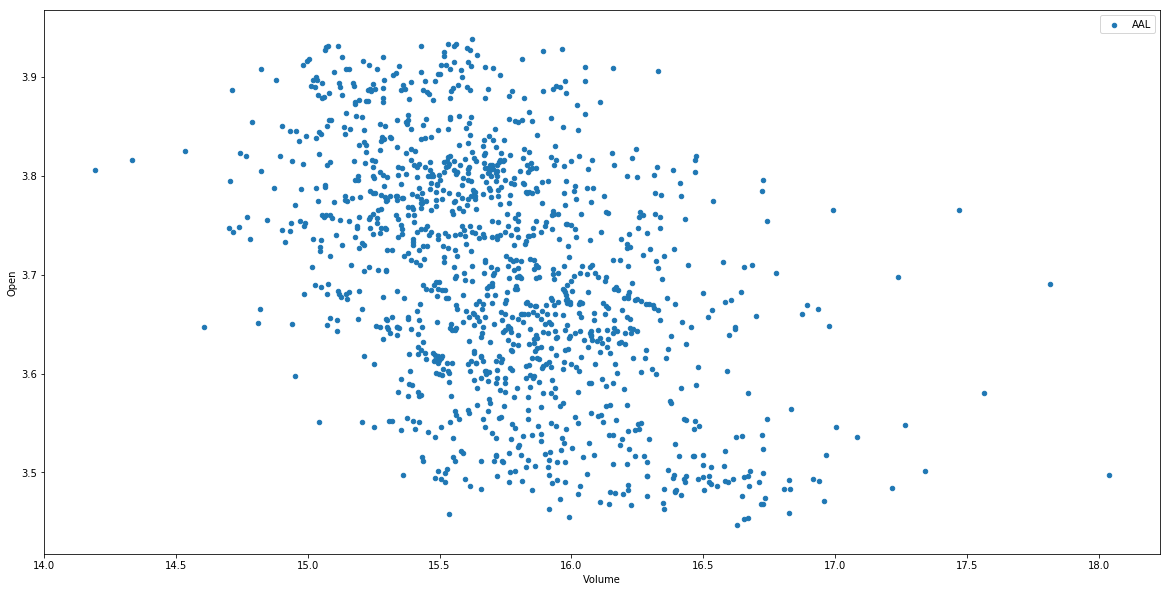

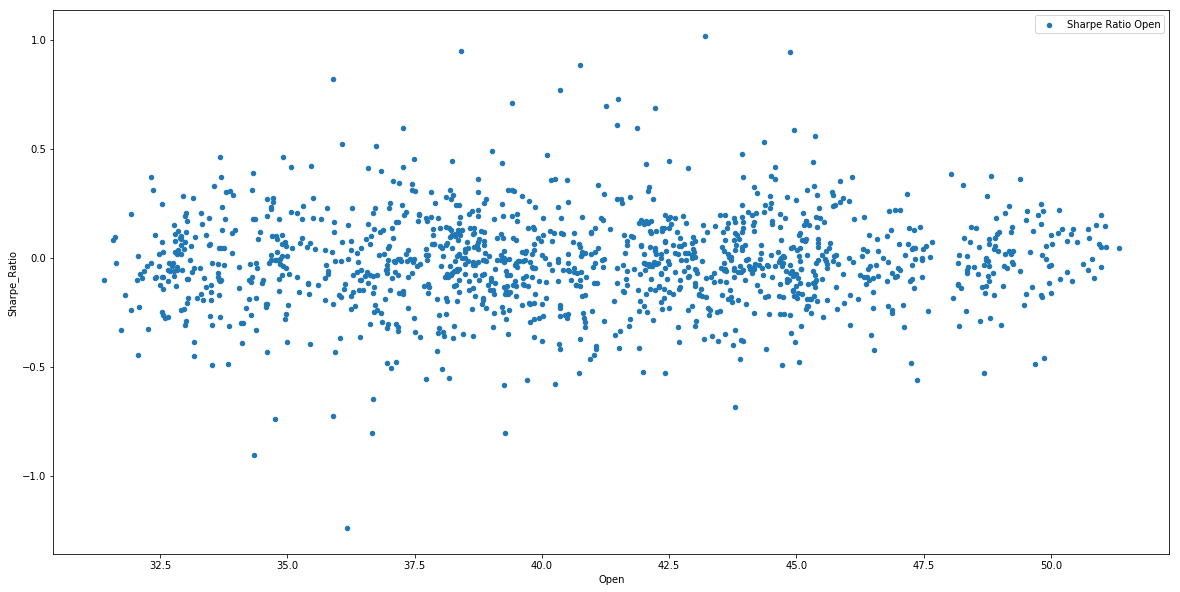

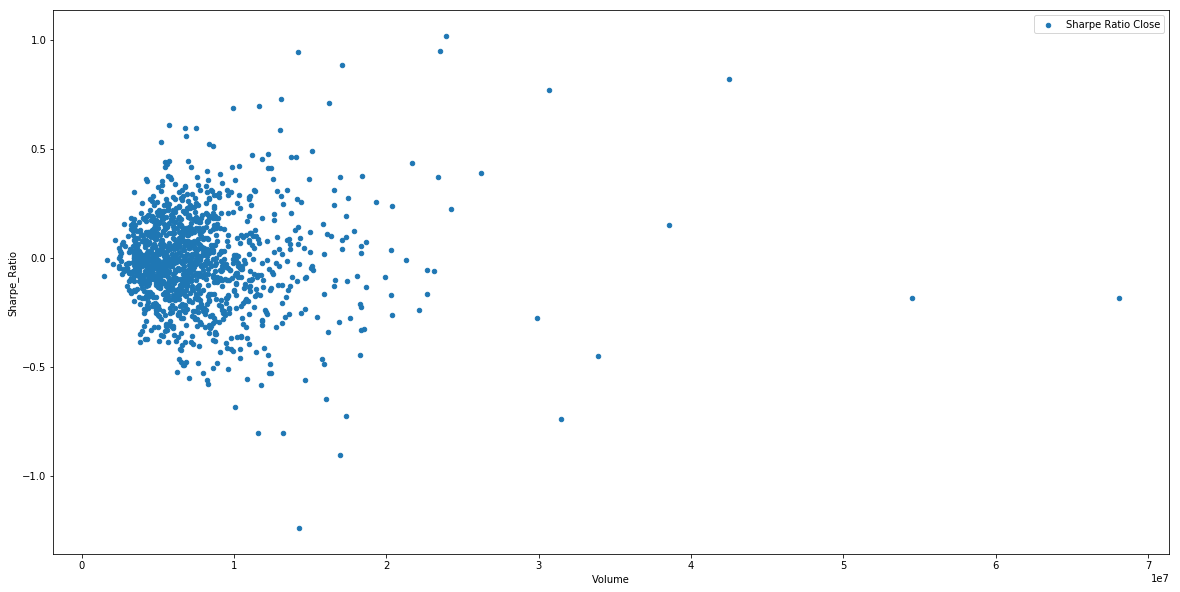

ACN


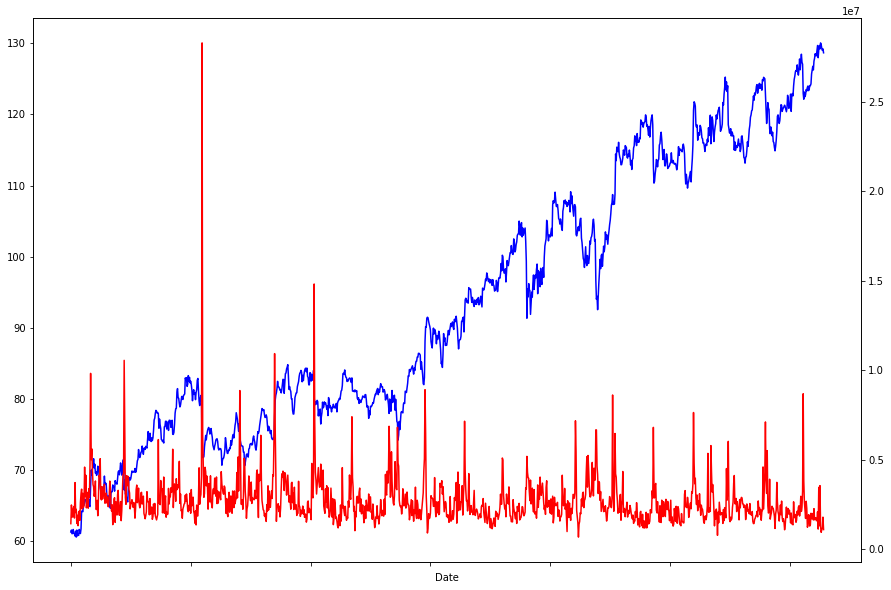

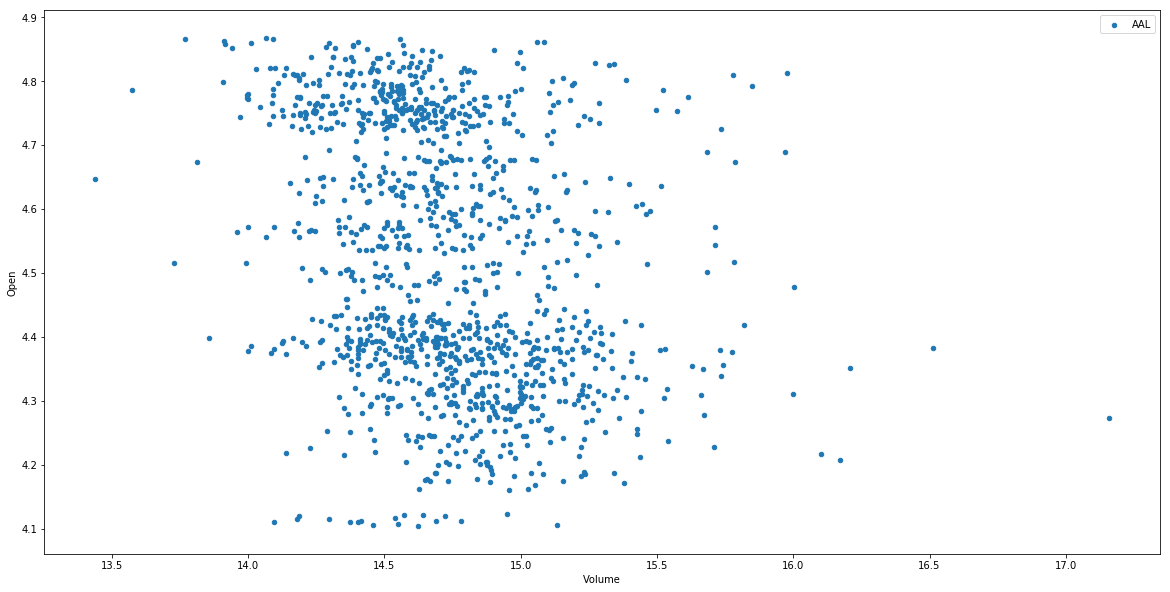

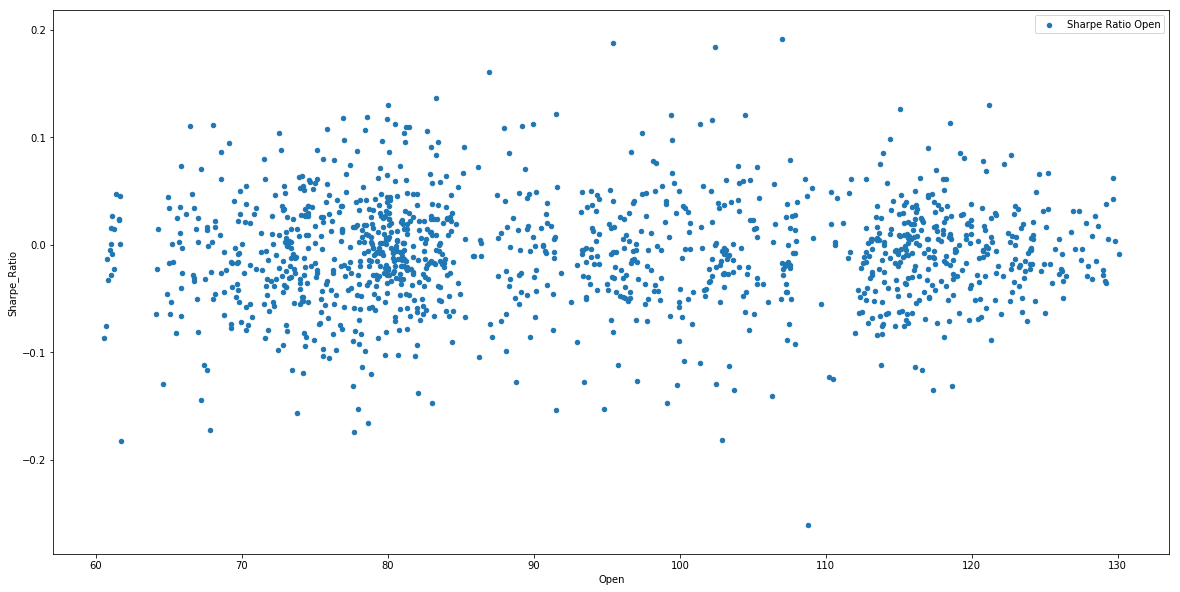

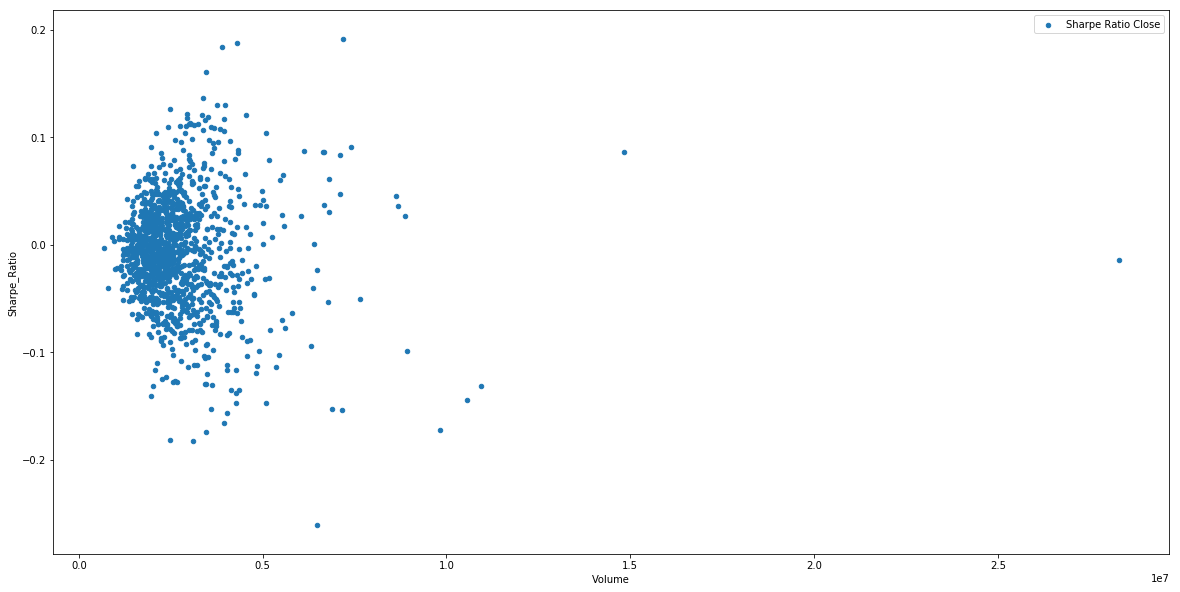

ADBE


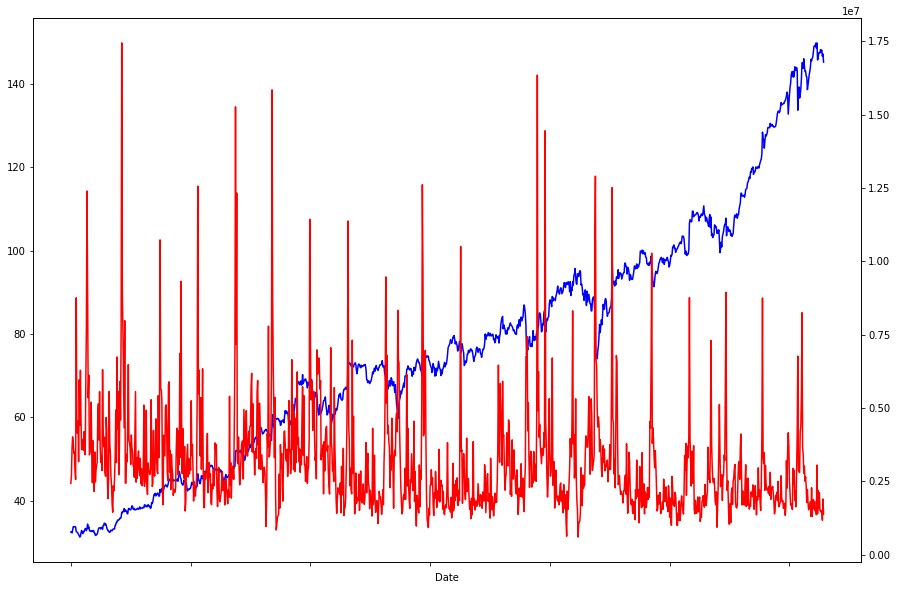

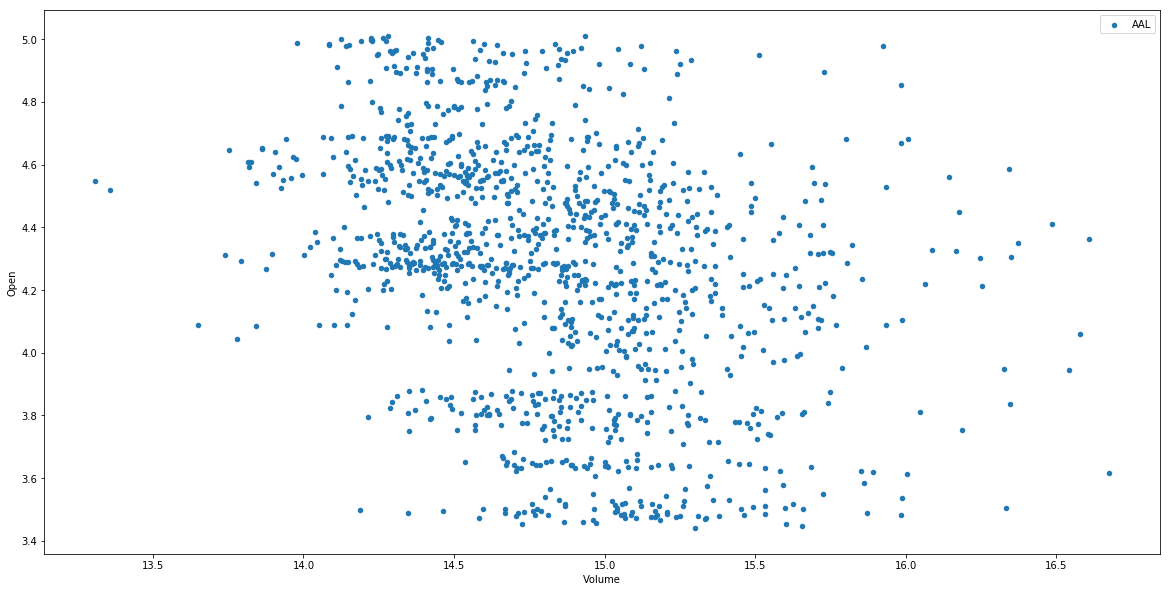

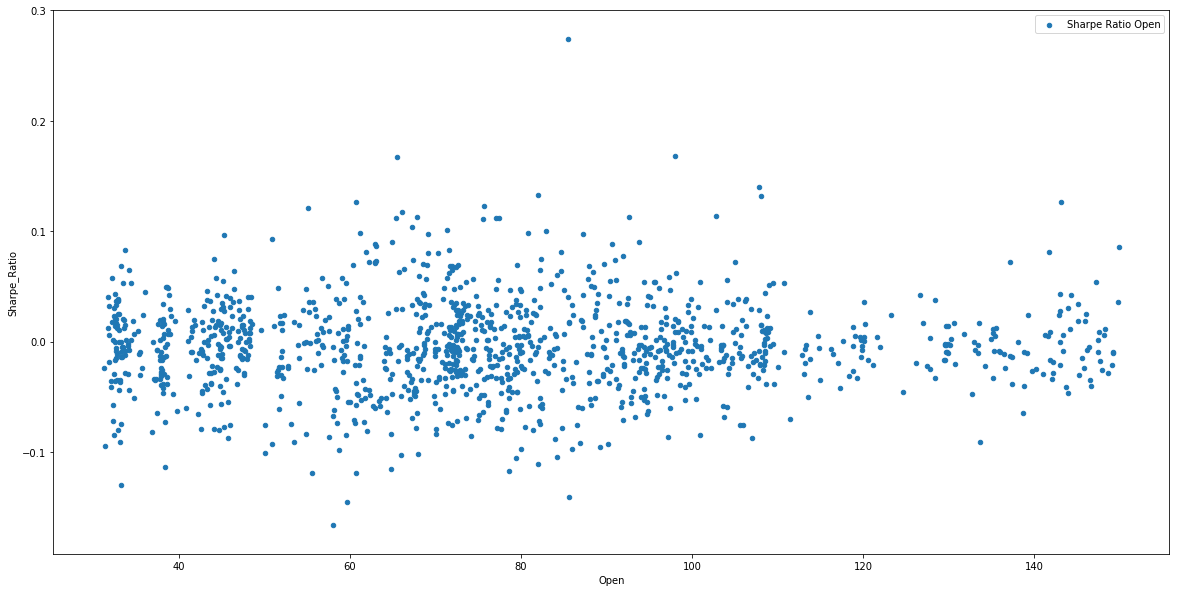

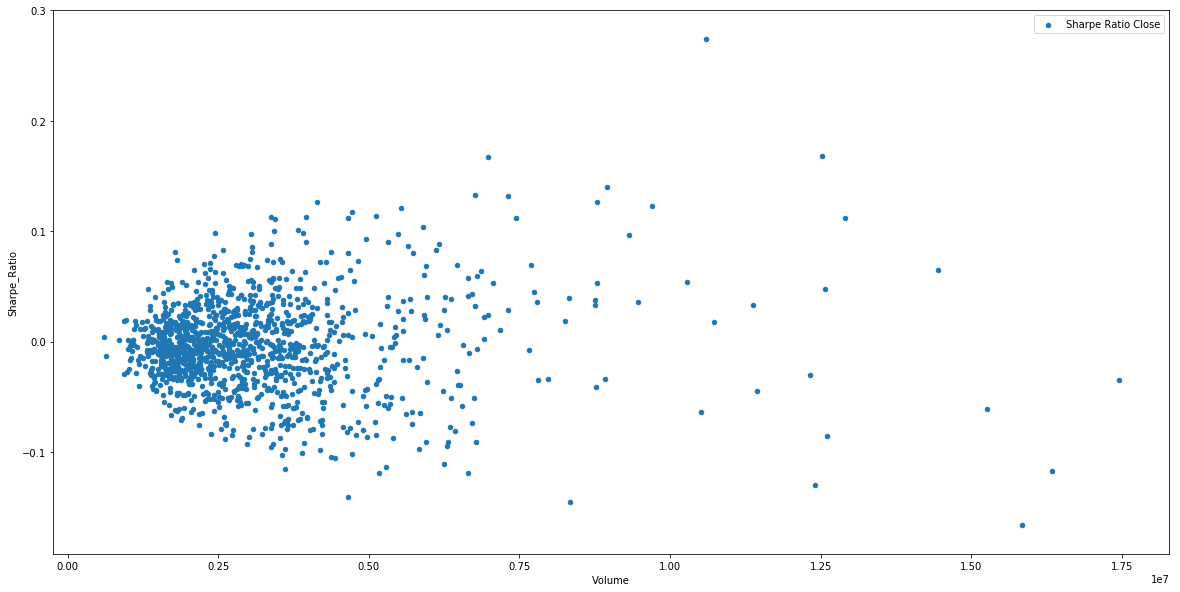

ADI


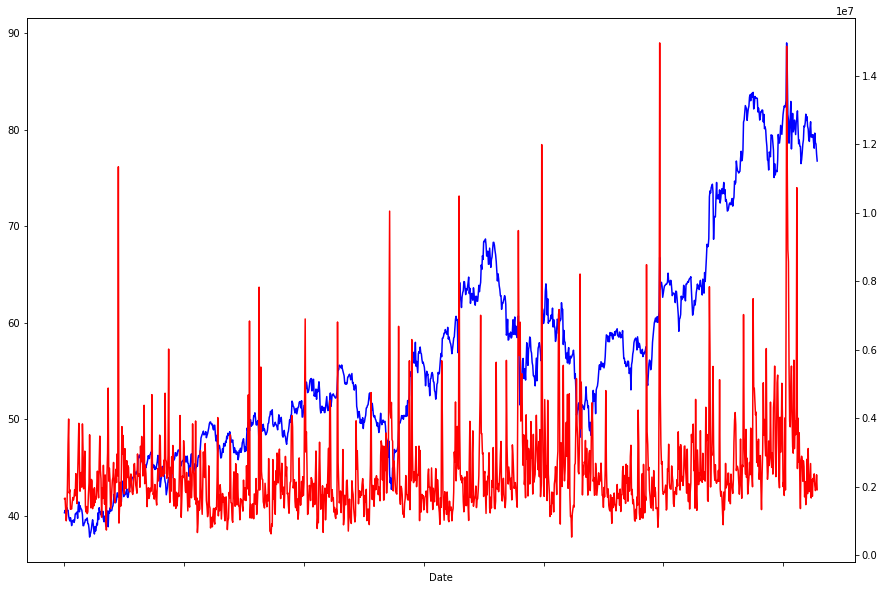

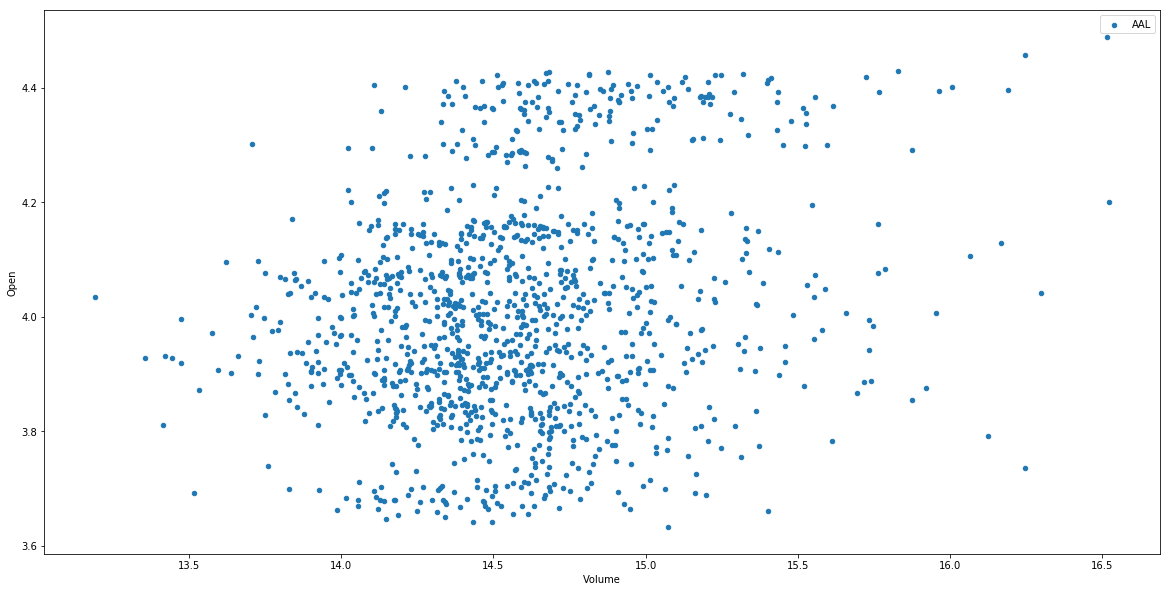

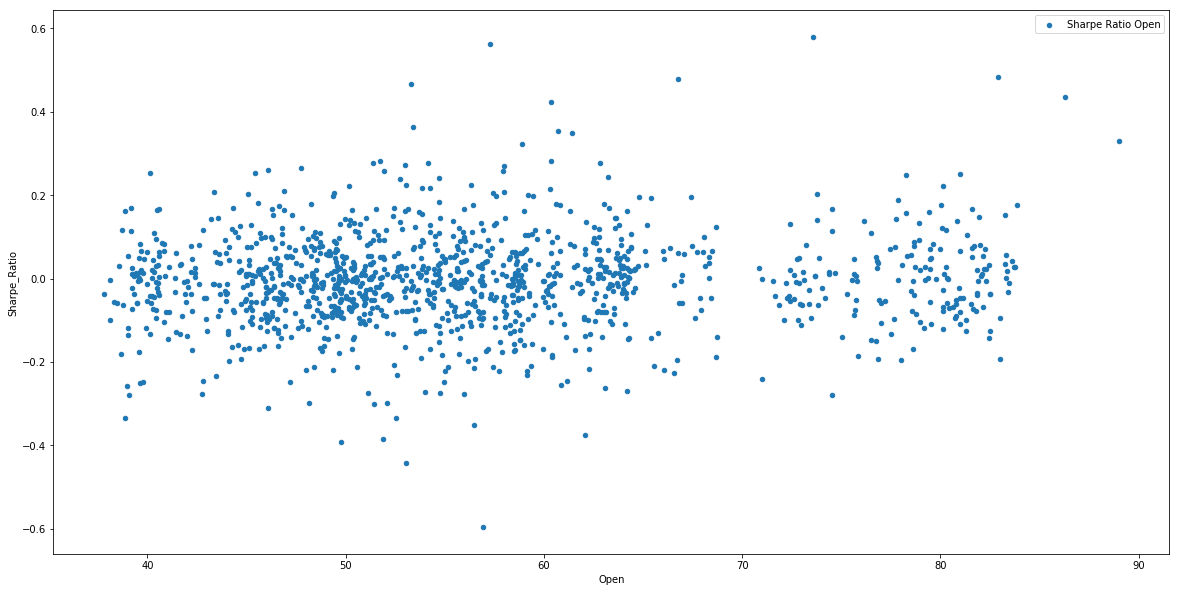

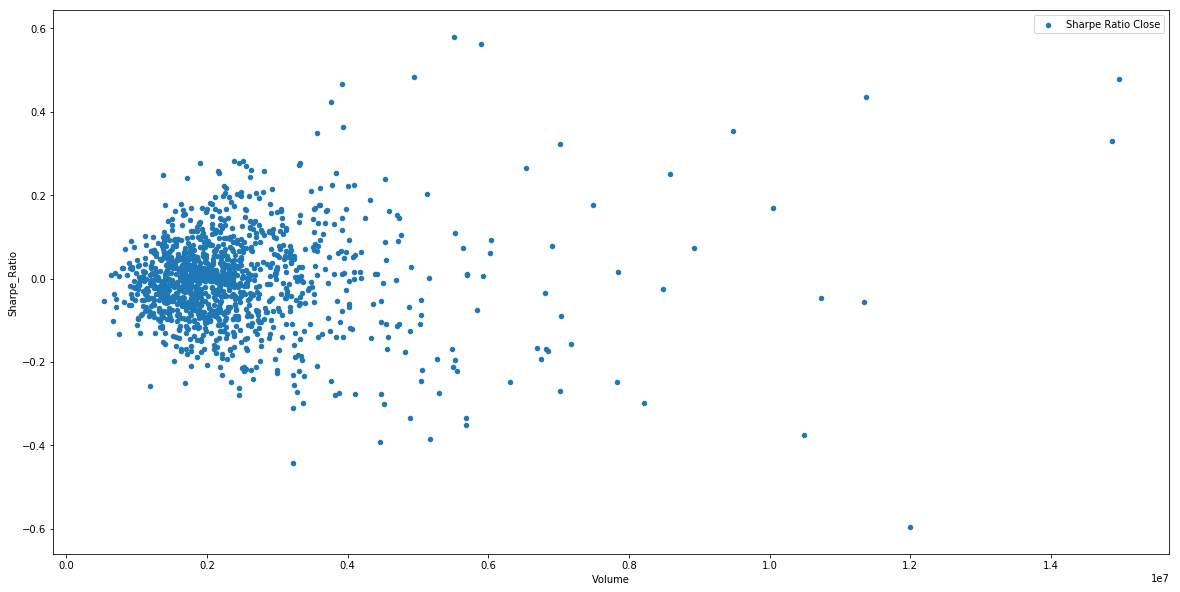

ADM


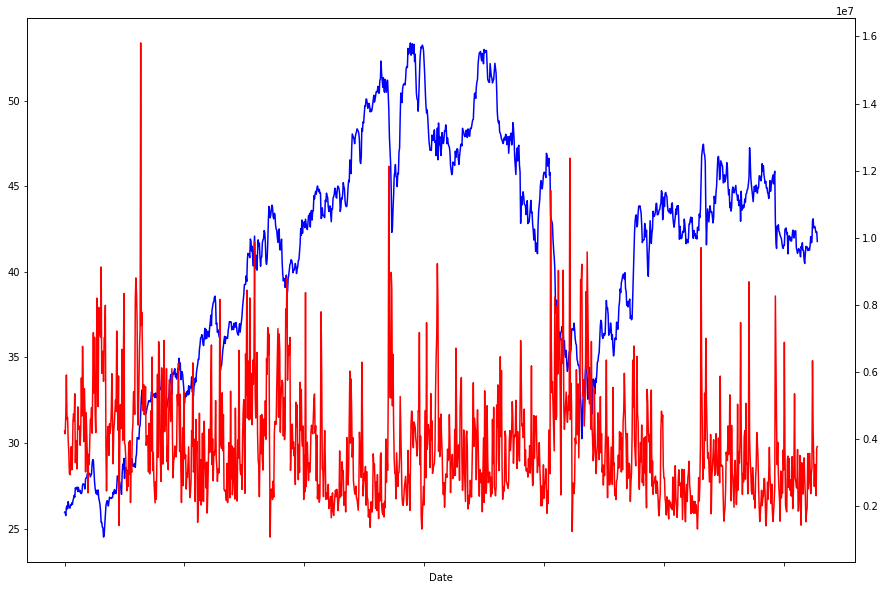

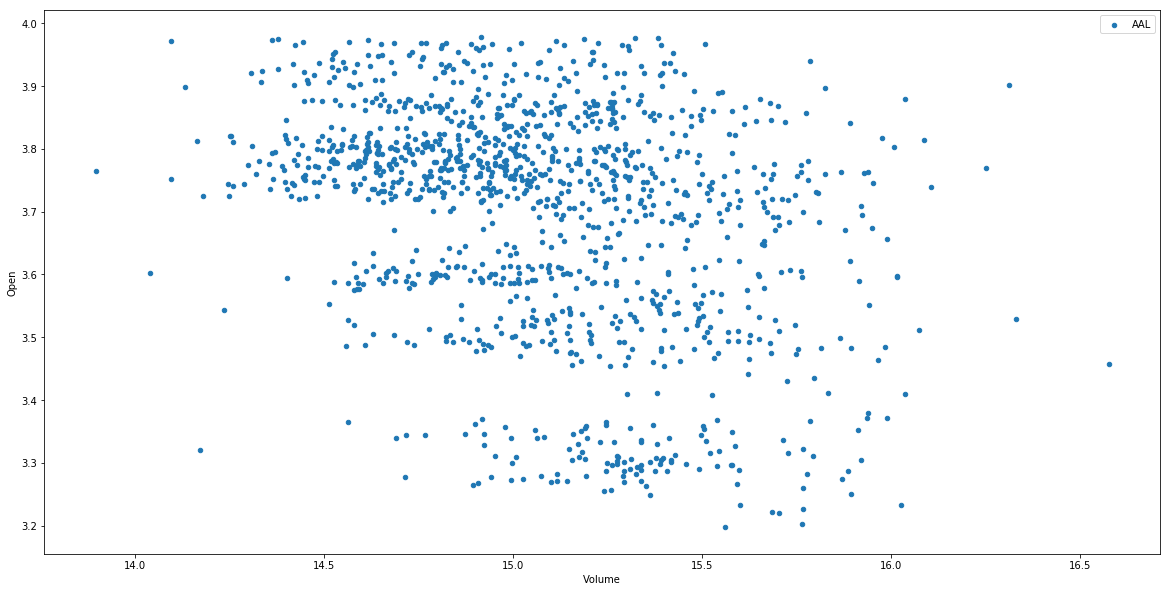

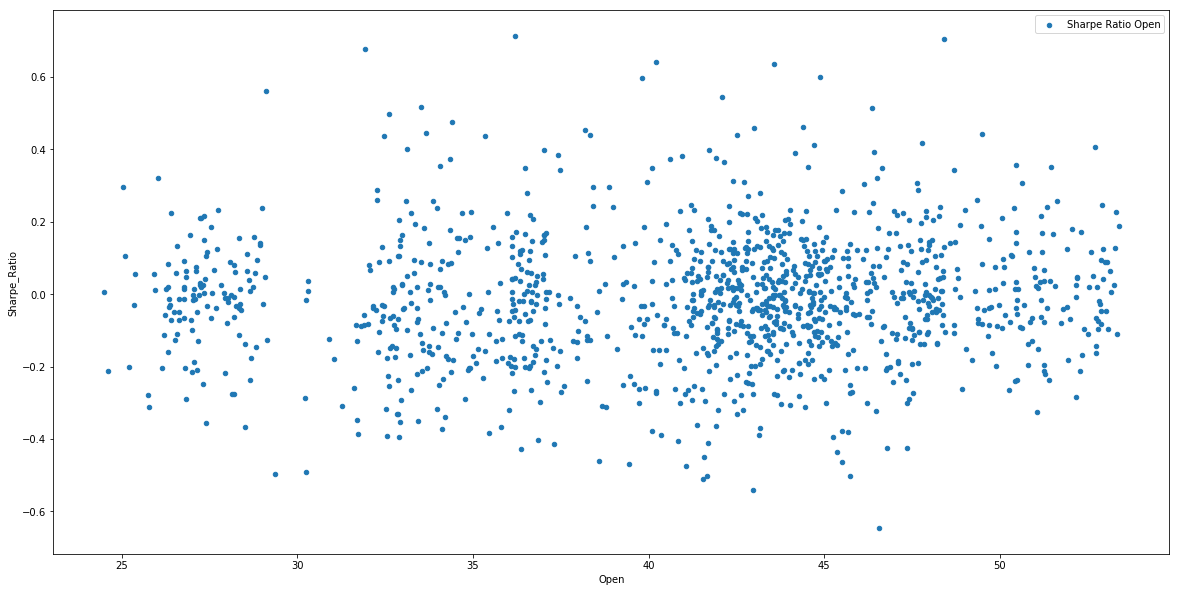

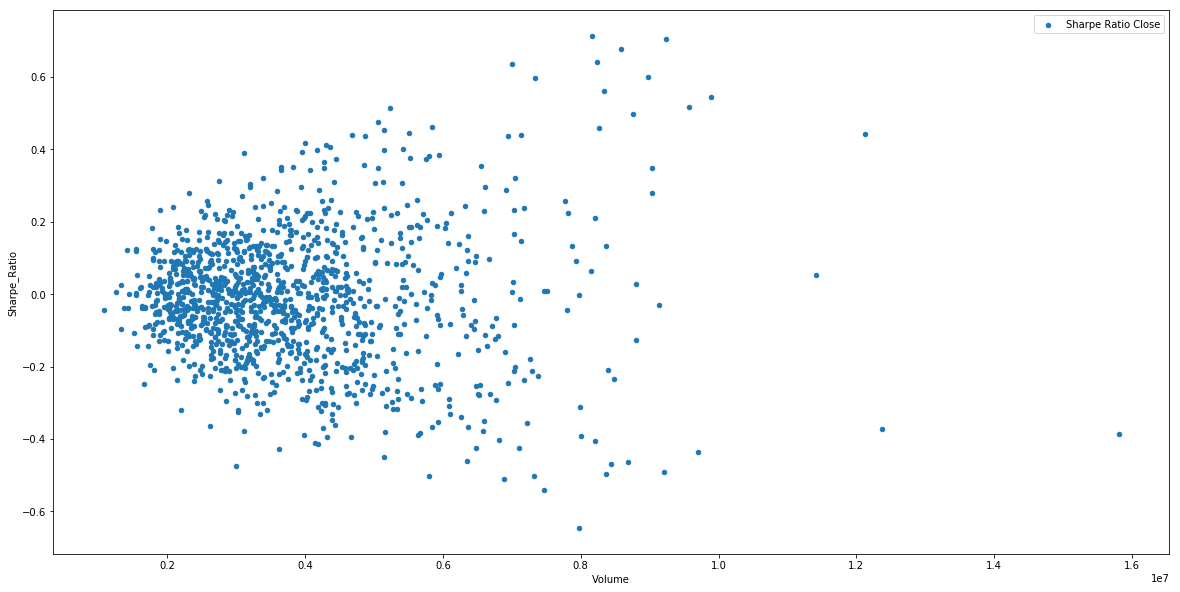

In [14]:
# printing out the first four stocks to get an idea of how each stock is individually represented.
plotting_stocks(symbols_list, 10)

In [18]:
from IPython.display import display

In [19]:
# I am using some of the techniques I learned from previous projects.  The below is from the Finding Donors Project.
closing = df_preprocessed['Close'].astype(int)
features = df_preprocessed.drop('Close', axis = 1)

#closing_raw
#features_raw

NameError: name 'df_preprocessed' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(features, closing, test_size=0.2, random_state=0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

In [ ]:
clf = SVC(random_state=2)

learner = clf.fit(X_train, y_train)

In [ ]:
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)*100

print("Accuracy is: {:.4f}%".format(accuracy))